In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import h5py
import os
import glob
import warnings
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

import sys
basedir = '/project/vitelli/jonathan/REDO_fruitfly/'
sys.path.insert(0, os.path.join(basedir, 'src'))

warnings.filterwarnings('ignore')


## Predict using learned model

Building mesh gradient operators
Loading order 0 from file
Loading order 1 from file
Loading order 2 from file
Initializing
Using torchdiffeq solver


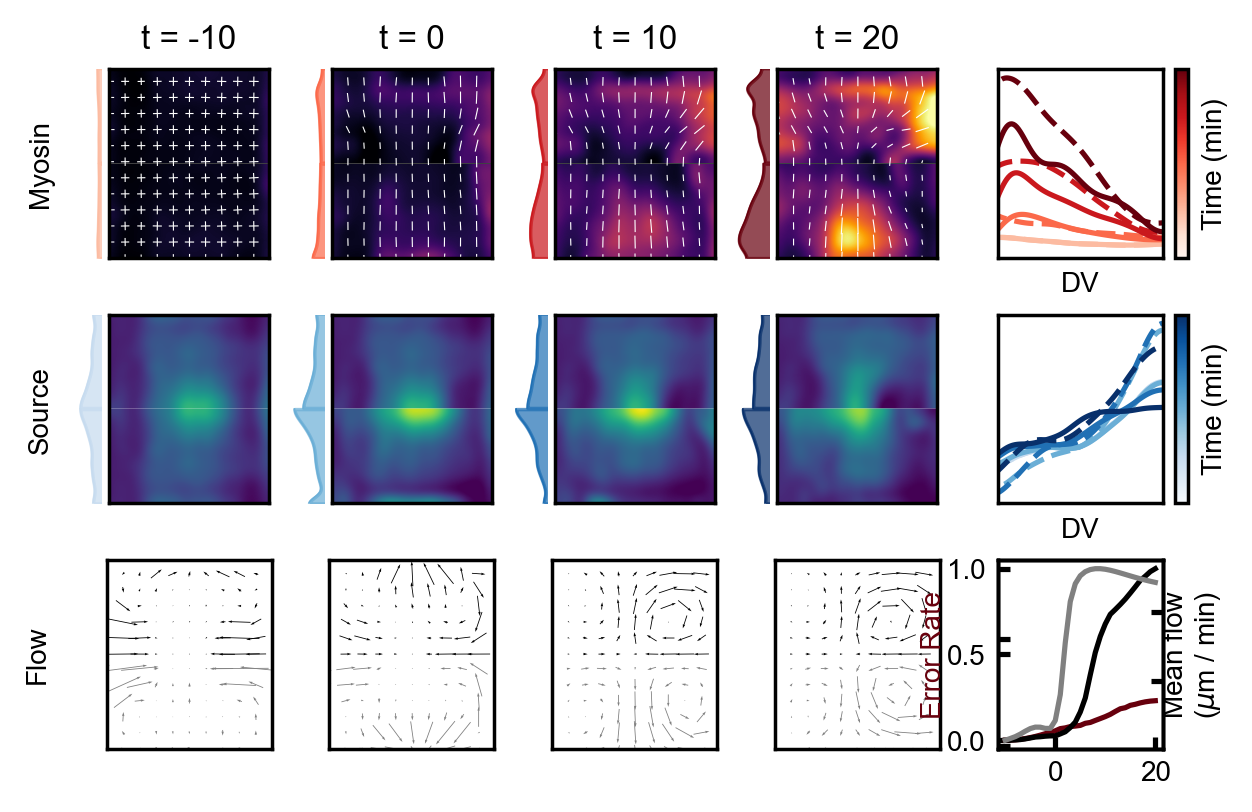

In [30]:
import torch
from utils.decomposition.decomposition_model import LeftRightSymmetrize
from utils.geometry.hybrid_loop import HybridClosedLoop
from utils.forecasting.plot_utils import *
from utils.vae.convnext_models import MaskedVAE_Evolver, VAE

info = torch.load('../tb_logs/March2023/MaskedVAE_Evolver_sqh_beta=0_split=embryo')
vae = MaskedVAE_Evolver(**info['hparams'])
vae.load_state_dict(info['state_dict'])

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
vae = vae.double().to(device).eval();
v_model = lambda t, y: VAE.forward(vae, y.reshape([-1, *y.shape[-3:]])[:, :4])[0]

#Collect initial conditions - m, c, v, and time
with h5py.File('Public/myosin_dynamics_fitting.h5', 'r') as h5f:
    data = h5f['ensemble']
    tmin, tmax = -10, 20
    
    t = data['fields/v'].attrs['t']
    t_mask = np.logical_and(t >= tmin, t <= tmax)
    m0 = data['fields/m_ij'][t_mask, ...][()]
    s0 = data['fields/c'][t_mask, ...][()]
    v0 = data['fields/v'][t_mask, ...][()]
    
    s0 = LeftRightSymmetrize().fit_transform(s0)
    t0 = t[t_mask, ...][()]
    
y0 = np.concatenate([
    m0[0].reshape([4, *m0.shape[-2:]]),
    s0[0].reshape([1, *s0.shape[-2:]]),
]) 
y0 = torch.from_numpy(y0)

model = HybridClosedLoop(v_model=v_model, 
                         sigma=7, 
                         mesh_name='embryo_poles_noll')
model.fit(y0[None])
model.to(device)
y0 = y0.to(device)

#Using a flow field interpolator in the loop instead of a neural network
#v_int = interp1d(t0, v0, axis=0, fill_value='extrapolate')
#v_model = lambda t, y: v_int(t)
#model = HybridClosedLoop(v_model=v_model)
#model.fit(y0[None])

m, s, v = model.integrate(y0, t0)
#sqh_vel_plot(m, v, t0, dt=5)
comparison_plot(t0,
                ('Myosin', m, m0),
                ('Source', s, s0),
                ('Flow', v, v0),
                dt=10, al=1)

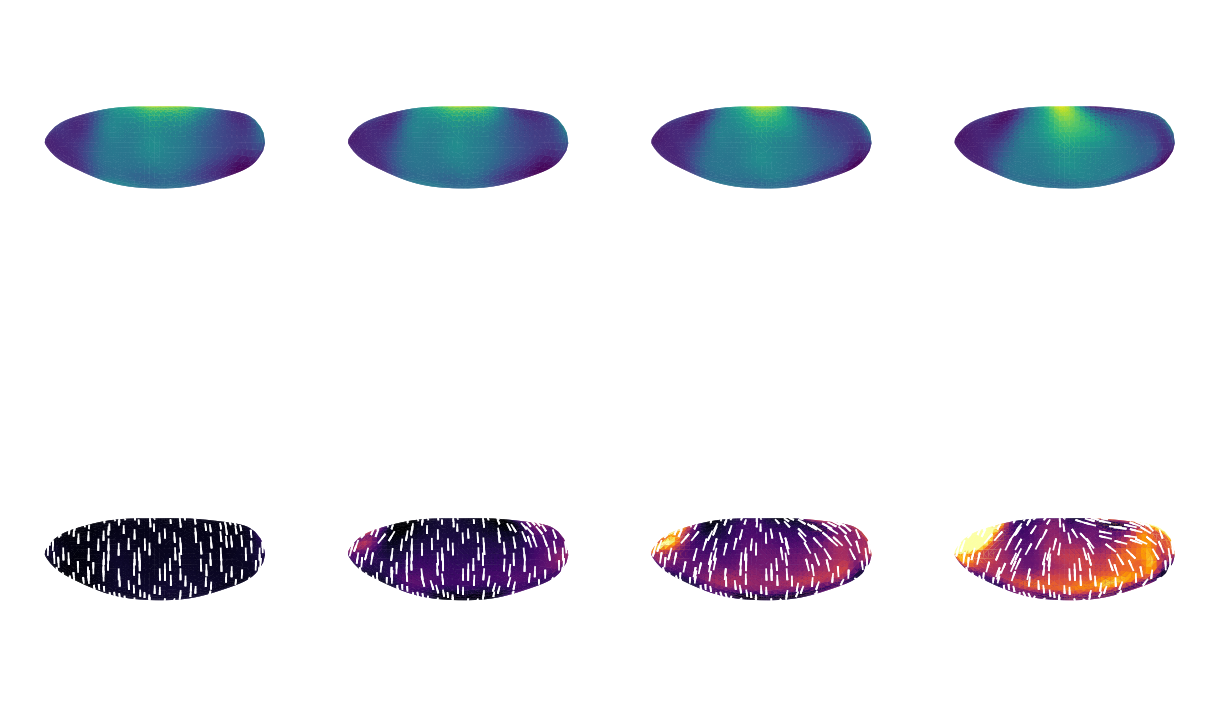

In [21]:
from utils.geometry.plot_utils import *
from utils.geometry.geometry_utils import *
from sklearn.pipeline import Pipeline
fig, ax = plt.subplots(2, 4, dpi=250, subplot_kw=dict(projection='3d'))

mnorm = np.linalg.norm(m0, axis=(1, 2))
vmin, vmax = np.min(mnorm), np.max(mnorm)
pipe = Pipeline([
    ('mesh', MeshInterpolator()),
    ('tangent', TangentSpaceTransformer()),
]).fit(mnorm)
    

for i in range(4):
    #plot_tensor3D(ax[0, i], pipe.transform(m0[i*10]), vmin=vmin, vmax=vmax)
    color_3D(ax[0, i], pipe.transform(s[i*10]))
    plot_tensor3D(ax[1, i], pipe.transform(m[i*10].reshape([2, 2, 236, 200])), vmin=vmin, vmax=vmax)